In [1]:
#!pip3 install bayesian-optimization==0.6 --user
#!pip3 install pip install bayesian-optimization --user
!pip3 install git+https://github.com/fmfn/BayesianOptimization

  Running command git clone --filter=blob:none --quiet https://github.com/fmfn/BayesianOptimization 'C:\Users\Cyberpower PC\AppData\Local\Temp\pip-req-build-bctdrals'



  Cloning https://github.com/fmfn/BayesianOptimization to c:\users\cyberpower pc\appdata\local\temp\pip-req-build-bctdrals
  Resolved https://github.com/fmfn/BayesianOptimization to commit 8ed5a3767634e5f47d0e3bf02b2dc11a6d241527
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


I use `bayesian-optimization==0.6`, my backend pretty much stick with this version, so migrating will break the code.

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from bayes_opt import BayesianOptimization
sns.set()
%matplotlib inline

In [3]:
import pkg_resources
import types


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

matplotlib==3.6.2
numpy==1.23.4
pandas==1.5.1
seaborn==0.12.1


In [4]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [5]:
df = pd.read_csv('.\\Data\AMC.csv')
display(df.head())
display(df.tail())

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,7.30,7.56,7.23,7.46,7.414512,4545900
1,2020-01-03,7.45,7.60,7.31,7.32,7.275366,2218000
2,2020-01-06,7.25,7.30,7.11,7.12,7.076585,2903400
3,2020-01-07,7.11,7.20,7.00,7.13,7.086524,3205300
4,2020-01-08,7.11,7.15,6.61,6.62,6.579634,6557000


,Date,Open,High,Low,Close,Adj Close,Volume
713,2022-10-31,6.82,7.25,6.54,6.66,6.66,34859100
714,2022-11-01,6.76,6.85,6.13,6.15,6.15,21354300
715,2022-11-02,6.26,6.33,5.79,5.81,5.81,22112800
716,2022-11-03,5.75,5.85,5.58,5.70,5.70,16543200
717,2022-11-04,5.83,5.85,5.42,5.65,5.65,17995000


In [6]:
close = df.Close.values.tolist()
window_size = 30
skip = 5
l = len(close) - 1

In [7]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [8]:
class Agent:
    def __init__(
        self,
        population_size,
        sigma,
        learning_rate,
        model,
        money,
        max_buy,
        max_sell,
        skip,
        window_size,
    ):
        self.window_size = window_size
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(close, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = get_state(close, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()

In [9]:
def best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    model = Model(window_size, size_network, 3)
    agent = Agent(
        population_size,
        sigma,
        learning_rate,
        model,
        1000,
        5,
        5,
        skip,
        window_size,
    )
    try:
        agent.fit(100, 110)
        return agent.es.reward_function(agent.es.weights)
    except:
        return 0

In [10]:
def find_best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    global accbest
    param = {
        'window_size': int(np.around(window_size)),
        'skip': int(np.around(skip)),
        'population_size': int(np.around(population_size)),
        'sigma': max(min(sigma, 1), 0.0001),
        'learning_rate': max(min(learning_rate, 0.5), 0.000001),
        'size_network': int(np.around(size_network)),
    }
    print('\nSearch parameters %s' % (param))
    investment = best_agent(**param)
    print('stop after 100 iteration with investment %f' % (investment))
    if investment > accbest:
        costbest = investment
    return investment

In [11]:
accbest = 0.0
NN_BAYESIAN = BayesianOptimization(
    find_best_agent,
    {
        'window_size': (2, 50),
        'skip': (1, 15),
        'population_size': (1, 90),
        'sigma': (0.01, 0.99),
        'learning_rate': (0.00001, 0.49),
        'size_network': (10, 1000),
    },
)
NN_BAYESIAN.maximize(init_points = 30, n_iter = 170, acq = 'ei', xi = 0.0)

|   iter    |  target   | learni... | popula... |   sigma   | size_n... |   skip    | window... |
-------------------------------------------------------------------------------------------------

Search parameters {'window_size': 42, 'skip': 6, 'population_size': 9, 'sigma': 0.12133057059036222, 'learning_rate': 0.3834690918834378, 'size_network': 223}
time taken to train: 15.984946012496948 seconds
stop after 100 iteration with investment 170.653996
| 1         | 170.7     | 0.3835    | 8.51      | 0.1213    | 222.9     | 5.64      | 41.72     |

Search parameters {'window_size': 47, 'skip': 5, 'population_size': 78, 'sigma': 0.7536951355871085, 'learning_rate': 0.3724917368817537, 'size_network': 25}
time taken to train: 22.719749212265015 seconds
stop after 100 iteration with investment 431.588998
| 2         | 431.6     | 0.3725    | 78.13     | 0.7537    | 24.93     | 4.898     | 46.65     |

Search parameters {'window_size': 35, 'skip': 11, 'population_size': 52, 'sigma': 0.5950

C:\Users\Cyberpower PC\AppData\Local\Temp\ipykernel_21240\1667285525.py:39: RuntimeWarning: invalid value encountered in divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
| 35        | 0.0       | 0.4083    | 70.86     | 0.1541    | 702.0     | 5.072     | 2.245     |

Search parameters {'window_size': 44, 'skip': 13, 'population_size': 8, 'sigma': 0.07963665781790175, 'learning_rate': 0.04988027732974434, 'size_network': 277}
time taken to train: 6.5585618019104 seconds
stop after 100 iteration with investment 94.137000
| 36        | 94.14     | 0.04988   | 8.235     | 0.07964   | 276.8     | 13.36     | 43.67     |

Search parameters {'window_size': 40, 'skip': 6, 'population_size': 19, 'sigma': 0.6610801022459454, 'learning_rate': 0.4333691072772821, 'size_network': 828}
time taken to train: 34.01463580131531 seconds
stop after 100 iteration with investment 444.094999
| 37        | 444.1     | 0.4334    | 18.89     | 0.6611    | 827.6     | 6.134     | 39.84     |

Search parameters {'window_size': 35, 'skip': 4, 'population_size': 78, 'sigma': 0.5210331449469628, 'learning_rate': 0.25101292917572116,

C:\Users\Cyberpower PC\AppData\Local\Temp\ipykernel_21240\1667285525.py:39: RuntimeWarning: invalid value encountered in divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
| 40        | 0.0       | 0.4345    | 3.415     | 0.06786   | 550.1     | 5.85      | 21.28     |

Search parameters {'window_size': 28, 'skip': 3, 'population_size': 57, 'sigma': 0.8063195964438824, 'learning_rate': 0.05570720275568546, 'size_network': 639}
time taken to train: 190.68182158470154 seconds
stop after 100 iteration with investment 445.870998
| 41        | 445.9     | 0.05571   | 56.52     | 0.8063    | 638.8     | 2.587     | 28.05     |

Search parameters {'window_size': 49, 'skip': 8, 'population_size': 54, 'sigma': 0.5410623471746984, 'learning_rate': 0.4200382530532205, 'size_network': 384}
time taken to train: 70.21308994293213 seconds
stop after 100 iteration with investment 356.738001
| 42        | 356.7     | 0.42      | 53.97     | 0.5411    | 384.1     | 8.304     | 49.27     |

Search parameters {'window_size': 25, 'skip': 5, 'population_size': 3, 'sigma': 0.689981732420489, 'learning_rate': 0.4142114608401368,

C:\Users\Cyberpower PC\AppData\Local\Temp\ipykernel_21240\1667285525.py:39: RuntimeWarning: invalid value encountered in divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


stop after 100 iteration with investment 0.000000
| 99        | 0.0       | 0.07375   | 74.25     | 0.02481   | 342.8     | 4.932     | 32.99     |

Search parameters {'window_size': 19, 'skip': 2, 'population_size': 76, 'sigma': 0.8419169264306482, 'learning_rate': 0.21979659167724486, 'size_network': 342}
time taken to train: 36.31130361557007 seconds
stop after 100 iteration with investment 560.675002
| 100       | 560.7     | 0.2198    | 75.71     | 0.8419    | 342.2     | 1.568     | 18.58     |

Search parameters {'window_size': 26, 'skip': 2, 'population_size': 72, 'sigma': 0.1709063549195085, 'learning_rate': 0.31790808999258213, 'size_network': 344}
time taken to train: 37.16688656806946 seconds
stop after 100 iteration with investment 791.568998
| 101       | 791.6     | 0.3179    | 71.97     | 0.1709    | 343.5     | 1.855     | 25.98     |

Search parameters {'window_size': 26, 'skip': 2, 'population_size': 70, 'sigma': 0.3489644026840112, 'learning_rate': 0.205739346016631

In [12]:
print('Best AGENT accuracy value: %f' % NN_BAYESIAN.max['target'])
print('Best AGENT parameters: ', NN_BAYESIAN.max['params'])

%matplotlib inline

Best AGENT accuracy value: 1180.430006
Best AGENT parameters:  {'learning_rate': 0.3897410183370632, 'population_size': 77.65001486505547, 'sigma': 0.49635542719906317, 'size_network': 333.8817831329766, 'skip': 1.2086940914173503, 'window_size': 41.35226080803451}


#### My selected parameters

In [13]:
best_agent(
    window_size = 30, 
    skip = 1, 
    population_size = 15, 
    sigma = 0.1, 
    learning_rate = 0.03, 
    size_network = 500
)

time taken to train: 147.54509949684143 seconds


828.0450018000005

#### bayesian parameters

In [14]:
best_agent(
    window_size = int(np.around(NN_BAYESIAN.max['params']['window_size'])), 
    skip = int(np.around(NN_BAYESIAN.max['params']['skip'])), 
    population_size = int(np.around(NN_BAYESIAN.max['params']['population_size'])), 
    sigma = NN_BAYESIAN.max['params']['sigma'], 
    learning_rate = NN_BAYESIAN.max['params']['learning_rate'], 
    size_network = int(np.around(NN_BAYESIAN.max['params']['size_network']))
)

time taken to train: 699.5493679046631 seconds


1039.2520115999994

#### My selected parameters

iter 100. reward: 959.970001
iter 200. reward: 1141.411006
iter 300. reward: 1084.393006
iter 400. reward: 1048.768009
iter 500. reward: 1171.480010
time taken to train: 596.388795375824 seconds
day 0: buy 1 units at price 7.460000, total balance 992.540000
day 1: buy 1 units at price 7.320000, total balance 985.220000
day 2: buy 1 units at price 7.120000, total balance 978.100000
day 3: buy 1 units at price 7.130000, total balance 970.970000
day 4: buy 1 units at price 6.620000, total balance 964.350000
day 5: buy 1 units at price 6.460000, total balance 957.890000
day 6: buy 1 units at price 6.470000, total balance 951.420000
day 7: buy 1 units at price 6.560000, total balance 944.860000
day 8: buy 1 units at price 6.850000, total balance 938.010000
day 9: buy 1 units at price 7.110000, total balance 930.900000
day 10: buy 1 units at price 7.330000, total balance 923.570000
day 11: buy 1 units at price 7.280000, total balance 916.290000
day 12: buy 1 units at price 7.180000, total ba

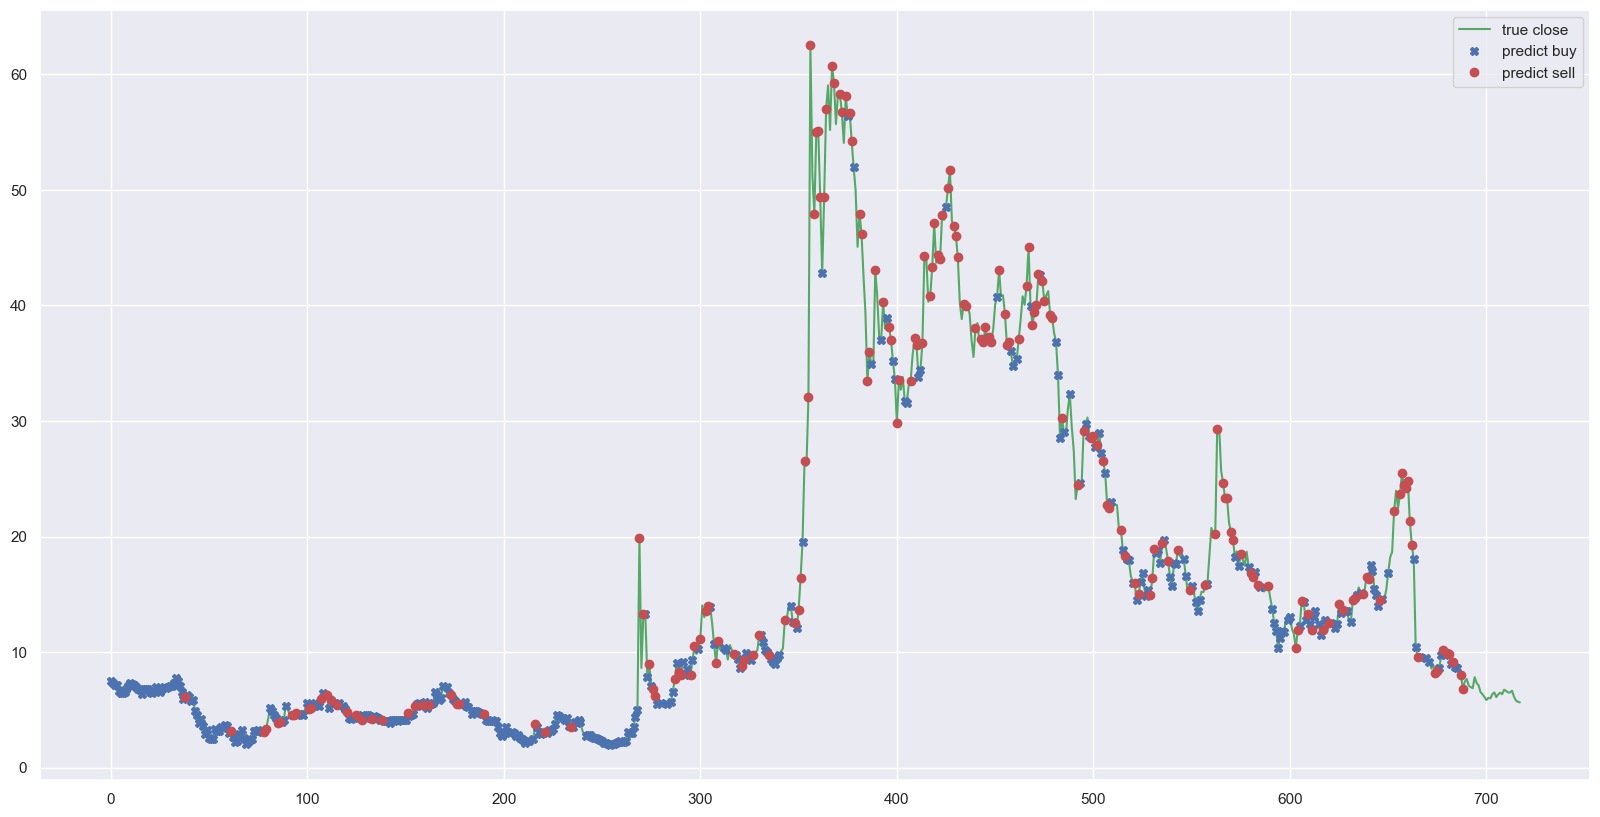

In [15]:
model = Model(input_size = 30, 
              layer_size = 500, 
              output_size = 3)
agent = Agent(population_size = 15, 
              sigma = 0.1, 
              learning_rate = 0.03, 
              model = model, 
              money = 1000, 
              max_buy = 5, 
              max_sell = 5, 
              skip = 1, 
              window_size = 30)
agent.fit(500, 100)
agent.buy()

#### bayesian parameters

In [16]:
model = Model(input_size = int(np.around(NN_BAYESIAN.max['params']['window_size'])), 
              layer_size = int(np.around(NN_BAYESIAN.max['params']['size_network'])), 
              output_size = 3)
agent = Agent(population_size = int(np.around(NN_BAYESIAN.max['params']['population_size'])), 
              sigma = NN_BAYESIAN.max['params']['sigma'], 
              learning_rate = NN_BAYESIAN.max['params']['learning_rate'], 
              model = model, 
              money = 1000, 
              max_buy = 5, 
              max_sell = 5, 
              skip = int(np.around(NN_BAYESIAN.max['params']['skip'])), 
              window_size = int(np.around(NN_BAYESIAN.max['params']['window_size'])))
agent.fit(500, 100)
agent.buy()



iter 100. reward: 1101.129005
iter 200. reward: 1308.005004
iter 300. reward: 1423.376002


In [ ]:
from datetime import datetime
print(datetime.now())